In [116]:
# References
# https://github.com/anh-tong/signax/tree/main/examples
# https://docs.kidger.site/diffrax/examples/neural_cde/

import math
import jax
import time
import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import diffrax
import equinox as eqx
from signax.module import SignatureTransform
from functools import partial
from fbm import FBM
from jax import lax
import matplotlib.pyplot as plt
from typing import Callable
import optax
import seaborn as sns
import scipy

# Deep Signatures for predicting Hurst exponent in fBM time series

In [88]:
def dataloader(arrays, batch_size, *, key):
    # taken from equinox documentation
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [101]:
def generate_data(key, n_paths_train, n_paths_test, n_steps):
    train_key, test_key = jr.split(key)
    X_train, Y_train = [], []
    X_test, Y_test = [], []
    # generate train
    hurst_exponents_train = jr.uniform(train_key, shape=(n_paths_train,), dtype=float, minval=0.2, maxval=0.8)
    for hurst in hurst_exponents_train:
        f = FBM(n_steps, float(hurst))
        X_train.append(jnp.array(f.fbm()))

    # generate test
    hurst_exponents_test = jr.uniform(test_key, shape=(n_paths_test,), dtype=float, minval=0.2, maxval=0.8)   
    for hurst in hurst_exponents_test:
        f = FBM(n_steps, float(hurst))
        X_test.append(jnp.array(f.fbm()))

    X_train = jnp.array(X_train)
    Y_train = hurst_exponents_train
    X_test = jnp.array(X_test)
    Y_test = hurst_exponents_test

    return (
        X_train[..., None],
        Y_train[..., None],
        X_test[..., None],
        Y_test[..., None],
    )

In [105]:
seed = 1234
key = jr.PRNGKey(seed)
data_key, loader_key, model_key = jr.split(key, 3)

n_paths_train = 1000
n_paths_test = 50
n_steps = 99
X_train, Y_train, X_test, Y_test = generate_data(data_key, n_paths_train, n_paths_test, n_steps)

iter_data = dataloader((X_train, Y_train), batch_size=128, key=loader_key)
optim = optax.adam(learning_rate=1e-3)

@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    assert pred_y.shape[0] == y.shape[0]
    return jnp.mean(jnp.square(pred_y - y))

@eqx.filter_jit
def make_step(model, x, y, opt_state):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
def _make_convs(input_size: int, layer_sizes, kernel_size, *, key):
    """Make a stack of Conv1d:

    The first layer has kernel size = `kernel_size`.
    The remaining layers has kernel size = 1
    """
    keys = jr.split(key, num=len(layer_sizes))
    convs = []
    first_conv = eqx.nn.Conv1d(
        in_channels=input_size,
        out_channels=layer_sizes[0],
        kernel_size=kernel_size,
        key=keys[0],
    )
    convs += [first_conv]
    last_conv_size = layer_sizes[0]
    for i, layer_size in enumerate(layer_sizes[1:]):
        conv = eqx.nn.Conv1d(
            in_channels=last_conv_size,
            out_channels=layer_size,
            kernel_size=1,
            key=keys[i + 1],
        )
        convs += [conv]
        last_conv_size = layer_size
    return convs


class Augment(eqx.nn.Sequential):
    """A stack of Conv1D, first Conv1D has kernel_size as input
    The remaining Conv1D has kernel_size = 1

    This allows to add original input and time dimension to the output
    """

    activation: Callable
    include_original: bool
    include_time: bool
    kernel_size: int

    def __init__(
        self,
        layers,
        include_original=True,
        include_time=True,
        kernel_size=3,
        activation=jax.nn.relu,
    ):
        self.layers = layers
        self.include_original = include_original
        self.include_time = include_time
        self.kernel_size = kernel_size
        self.activation = activation

    def __call__(
        self,
        x: jnp.ndarray,
        *,
        key=None,
    ):
        """x size (length, dim)"""
        length, _ = x.shape
        ret = []
        if self.include_original:
            start_index = self.kernel_size - 1
            truncated_x = x[start_index:]
            ret.append(truncated_x)
        if self.include_time:
            time = jnp.linspace(0, 1, length - self.kernel_size + 1)
            time = time[:, None]
            ret.append(time)
        augmented_x = self.layers[0](x.transpose())
        for layer in self.layers[1:]:
            augmented_x = self.activation(augmented_x)
            augmented_x = layer(augmented_x)
        ret.append(augmented_x.transpose())
        return jnp.concatenate(ret, axis=-1)



def signature_dim(n_channels, depth):
    return sum([n_channels ** (i + 1) for i in range(depth)])


def create_simple_net(
    dim=1,
    signature_depth=4,
    augment_layer_size=(8, 8, 2),
    augmented_kernel_size=1,
    augmented_include_original=True,
    augmented_include_time=True,
    mlp_width=32,
    mlp_depth=2,
    output_size=1,
    final_activation=jax.nn.sigmoid,
    *,
    key,
):
    augment_key, mlp_key = jr.split(key)

    # create Convolutional augmented layers
    convs = _make_convs(
        input_size=dim,
        layer_sizes=augment_layer_size,
        kernel_size=augmented_kernel_size,
        key=augment_key,
    )
    augment = Augment(
        layers=convs,
        include_original=augmented_include_original,
        include_time=augmented_include_time,
        kernel_size=augmented_kernel_size,
    )

    signature = SignatureTransform(depth=signature_depth)

    # calculate output dimension of Agument
    last_dim = augment_layer_size[-1]
    if augmented_include_original:
        last_dim += dim
    if augmented_include_time:
        last_dim += 1
    # the output dimension of signature
    mlp_input_dim = signature_dim(n_channels=last_dim, depth=signature_depth)
    mlp = eqx.nn.MLP(
        in_size=mlp_input_dim,
        width_size=mlp_width,
        depth=mlp_depth,
        out_size=output_size,
        final_activation=final_activation,
        key=mlp_key,
    )
    layers = [augment, signature, mlp]

    return eqx.nn.Sequential(layers=layers)

In [94]:
model = create_simple_net(
    dim=1,
    signature_depth=3,
    augment_layer_size=(3,),
    augmented_kernel_size=3,
    mlp_width=32,
    mlp_depth=5,
    output_size=1,
    final_activation=jax.nn.sigmoid,
    key=model_key,
)

opt_state = optim.init(eqx.filter(model, eqx.is_array))
test_mse = []
for step, (x, y) in zip(range(500), iter_data):
    loss, model, opt_state = make_step(model, x, y, opt_state)
    loss = loss.item()
    test_mse += [jnp.mean(jnp.square(jax.vmap(model)(X_test) - Y_test)).item()]
    if step % 10 == 0:
        print(f"step={step} \t loss={loss}")

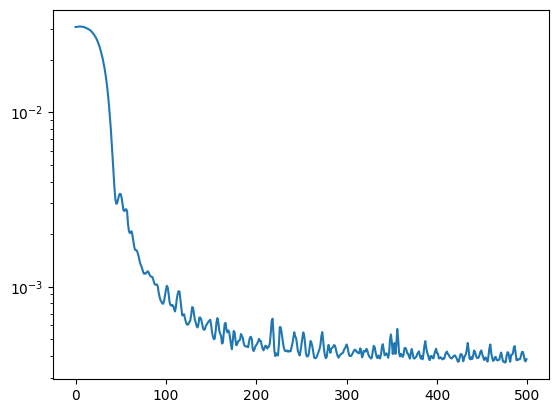

In [99]:
plt.plot(test_mse)
plt.yscale("log")

In [85]:
def r2(x, y):
    return scipy.stats.pearsonr(x, y)[0] ** 2

0.9873734340747465

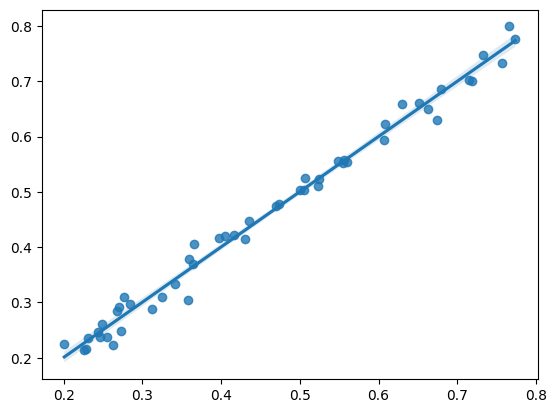

In [100]:
sns.regplot(x=jax.vmap(model)(X_test), y=Y_test)
r2(jax.vmap(model)(X_test)[:,0], Y_test[:,0])

# Neural CDEs for time series classification

In [110]:
def get_data(dataset_size, add_noise, *, key):
    theta_key, noise_key = jr.split(key, 2)
    length = 100
    theta = jr.uniform(theta_key, (dataset_size,), minval=0, maxval=2 * math.pi)
    y0 = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=-1)
    ts = jnp.broadcast_to(jnp.linspace(0, 4 * math.pi, length), (dataset_size, length))
    matrix = jnp.array([[-0.3, 2], [-2, -0.3]])
    ys = jax.vmap(
        lambda y0i, ti: jax.vmap(lambda tij: jsp.linalg.expm(tij * matrix) @ y0i)(ti)
    )(y0, ts)
    ys = jnp.concatenate([ts[:, :, None], ys], axis=-1)  # time is a channel
    ys = ys.at[: dataset_size // 2, :, 1].multiply(-1)
    if add_noise:
        ys = ys + jr.normal(noise_key, ys.shape) * 0.1
    coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(ts, ys)
    labels = jnp.zeros((dataset_size,))
    labels = labels.at[: dataset_size // 2].set(1.0)
    _, _, data_size = ys.shape
    return ts, coeffs, labels, data_size

In [111]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    data_size: int
    hidden_size: int

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.data_size = data_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            # Note the use of a tanh final activation function. This is important to
            # stop the model blowing up. (Just like how GRUs and LSTMs constrain the
            # rate of change of their hidden states.)
            final_activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y).reshape(self.hidden_size, self.data_size)

In [112]:
class NeuralCDE(eqx.Module):
    initial: eqx.nn.MLP
    func: Func
    linear: eqx.nn.Linear

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3)
        self.initial = eqx.nn.MLP(data_size, hidden_size, width_size, depth, key=ikey)
        self.func = Func(data_size, hidden_size, width_size, depth, key=fkey)
        self.linear = eqx.nn.Linear(hidden_size, 1, key=lkey)

    def __call__(self, ts, coeffs, evolving_out=False):
        # Each sample of data consists of some timestamps `ts`, and some `coeffs`
        # parameterising a control path. These are used to produce a continuous-time
        # input path `control`.
        control = diffrax.CubicInterpolation(ts, coeffs)
        term = diffrax.ControlTerm(self.func, control).to_ode()
        solver = diffrax.Tsit5()
        dt0 = None
        y0 = self.initial(control.evaluate(ts[0]))
        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=saveat,
        )
        if evolving_out:
            prediction = jax.vmap(lambda y: jnn.sigmoid(self.linear(y))[0])(solution.ys)
        else:
            (prediction,) = jnn.sigmoid(self.linear(solution.ys[-1]))
        return prediction

In [117]:
dataset_size=256
add_noise=False
batch_size=32
lr=1e-3
steps=50
hidden_size=8
width_size=128
depth=1
seed=5678

key = jr.PRNGKey(seed)
train_data_key, test_data_key, model_key, loader_key = jr.split(key, 4)

ts, coeffs, labels, data_size = get_data(dataset_size, add_noise, key=train_data_key)

model = NeuralCDE(data_size, hidden_size, width_size, depth, key=model_key)

# Training loop like normal.

@eqx.filter_jit
def loss(model, ti, label_i, coeff_i):
    pred = jax.vmap(model)(ti, coeff_i)
    # Binary cross-entropy
    bxe = label_i * jnp.log(pred) + (1 - label_i) * jnp.log(1 - pred)
    bxe = -jnp.mean(bxe)
    acc = jnp.mean((pred > 0.5) == (label_i == 1))
    return bxe, acc

grad_loss = eqx.filter_value_and_grad(loss, has_aux=True)

@eqx.filter_jit
def make_step(model, data_i, opt_state):
    ti, label_i, *coeff_i = data_i
    (bxe, acc), grads = grad_loss(model, ti, label_i, coeff_i)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return bxe, acc, model, opt_state

optim = optax.adam(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
for step, data_i in zip(
    range(steps), dataloader((ts, labels) + coeffs, batch_size, key=loader_key)
):
    start = time.time()
    bxe, acc, model, opt_state = make_step(model, data_i, opt_state)
    end = time.time()
    print(
        f"Step: {step}, Loss: {bxe}, Accuracy: {acc}, Computation time: "
        f"{end - start}"
    )

ts, coeffs, labels, _ = get_data(dataset_size, add_noise, key=test_data_key)
bxe, acc = loss(model, ts, labels, coeffs)
print(f"Test loss: {bxe}, Test Accuracy: {acc}")

Step: 0, Loss: 2.515748977661133, Accuracy: 0.5, Computation time: 3.0465970039367676
Step: 1, Loss: 1.3990858793258667, Accuracy: 0.5, Computation time: 0.09597492218017578
Step: 2, Loss: 0.53861403465271, Accuracy: 0.75, Computation time: 0.1105198860168457
Step: 3, Loss: 0.9186202883720398, Accuracy: 0.59375, Computation time: 0.11386990547180176
Step: 4, Loss: 0.9895105361938477, Accuracy: 0.4375, Computation time: 0.09243488311767578
Step: 5, Loss: 0.7512817978858948, Accuracy: 0.59375, Computation time: 0.11015009880065918
Step: 6, Loss: 0.7907160520553589, Accuracy: 0.5625, Computation time: 0.11466288566589355
Step: 7, Loss: 0.6401894092559814, Accuracy: 0.65625, Computation time: 0.09725689888000488
Step: 8, Loss: 0.4611627161502838, Accuracy: 0.84375, Computation time: 0.10310602188110352
Step: 9, Loss: 0.5488717555999756, Accuracy: 0.65625, Computation time: 0.09413814544677734
Step: 10, Loss: 0.5377901792526245, Accuracy: 0.65625, Computation time: 0.08692097663879395
Step: